In [1]:
import geopandas as gpd
from shapely.geometry import LineString
import pandas as pd
import numpy as np
import networkx as nx
import sqlite3
import matplotlib as mpl
import matplotlib.pyplot as plt
import matplotlib.patches as mpatches


/opt/homebrew/lib/python3.9/site-packages/geopandas/_compat.py:111: UserWarning: The Shapely GEOS version (3.10.2-CAPI-1.16.0) is incompatible with the GEOS version PyGEOS was compiled with (3.10.1-CAPI-1.16.0). Conversions between both will be slow.
  warnings.warn(


In [2]:
worldMap = gpd.read_file(gpd.datasets.get_path('naturalearth_lowres'))
worldMap.loc[worldMap['name'] == 'France', 'iso_a3'] = 'FRA'
worldMap.loc[worldMap['name'] == 'Norway', 'iso_a3'] = 'NOR'
worldMap.loc[worldMap['name'] == 'N. Cyprus', 'iso_a3'] = 'CYP'
worldMap.loc[worldMap['name'] == 'Somaliland', 'iso_a3'] = 'SOM'
worldMap.loc[worldMap['name'] == 'Kosovo', 'iso_a3'] = 'RKS'

In [3]:
with sqlite3.connect('../../Dataset/submarine_cable.sqlite') as con:
    c = con.cursor()
    cable_coor = pd.read_sql("select  geometry, lp.cable_id, lp.cable_name, cmlcc.merge_length as cable_length, cmlcc.merge_capacity as capacity, cmlcc.merge_cost as cost from landing_points lp left join cable_coor cc on lp.cable_id = cc.id left join cable_merge_length_capacity_cost cmlcc on lp.cable_id = cmlcc.cable_id group by geometry",con=con)
# cable_shap = gpd.GeoDataFrame(cable_coor, crs=4326)

In [4]:
cable_coor

,geometry,cable_id,cable_name,cable_length,capacity,cost
0,MULTILINESTRING ((-0.134425668831739 50.828479...,crosschannel-fibre,CrossChannel Fibre,149.0,2400.000000,3.875
1,MULTILINESTRING ((-0.204315619320994 5.5582858...,glo-1,Glo-1,9800.0,2.500000,260.000
2,MULTILINESTRING ((-0.376975497007066 39.459646...,balalink,Balalink,274.0,0.248790,6.825
3,MULTILINESTRING ((-1.617778330734808 54.978249...,no-uk,NO-UK,713.0,216.000000,20.000
4,MULTILINESTRING ((-1.968324369680687 46.693996...,dunant,Dunant,6400.0,250.000000,165.000
...,...,...,...,...,...,...
504,MULTILINESTRING ((9.768227316036075 1.86015040...,ceiba-1,Ceiba-1,287.0,4.432129,7.175
505,MULTILINESTRING ((90.45001016030389 -18.880139...,oman-australia-cable-oac,Oman Australia Cable (OAC),9800.0,39.000000,242.500
506,MULTILINESTRING ((92.72647339138612 11.6233755...,chennai-andaman-nicobar-islands-cable,Chennai-Andaman & Nicobar Islands Cable,2300.0,25.600000,170.000
507,MULTILINESTRING ((96.2482060528076 16.75877227...,singapore-myanmar-sigmar,Singapore-Myanmar (SIGMAR),2227.0,140.458488,80.000


In [5]:
cable_coor["geometry"] = cable_coor["geometry"].str.replace("MULTILINESTRING \(\(", "").str.replace("\)", "").str.replace("'","")


data = pd.DataFrame()

for row in range(cable_coor.shape[0]):
    coor_list = cable_coor.iloc[row,0].split(', (')
    for x in coor_list:
        seg = pd.DataFrame()
        abc = x.split(', ')
        # print(abc)
        for y in abc:
            a = {'lon1': y.split(' ')[0], 'lat1': y.split(' ')[1], 'capacity': cable_coor.iloc[row,cable_coor.columns.get_loc('capacity')], 'cost': cable_coor.iloc[row,cable_coor.columns.get_loc('cost')], 'cable_id': cable_coor.iloc[row,cable_coor.columns.get_loc('cable_id')], 'cable_name': cable_coor.iloc[row,cable_coor.columns.get_loc('cable_name')]}
            seg = seg.append(a,ignore_index=True)
        seg["lon1"] = seg["lon1"].astype("float64")
        seg["lat1"] = seg["lat1"].astype("float64")
        seg['lon2'] = seg['lon1'].shift()
        seg['lat2'] = seg['lat1'].shift()
        seg["capacity"] = seg["capacity"].astype("float64")
        seg["cost"] = seg["cost"].astype("float64")
        # seg["pair"] = seg["pair"].astype("float64")
        
        data = data.append(seg.dropna(),ignore_index=True)
data

/var/folders/93/98m4gg790h36hw_xcd31b1d40000gn/T/ipykernel_69330/6772599.py:1: FutureWarning: The default value of regex will change from True to False in a future version.
  cable_coor["geometry"] = cable_coor["geometry"].str.replace("MULTILINESTRING \(\(", "").str.replace("\)", "").str.replace("'","")


,lon1,lat1,capacity,cost,cable_id,cable_name,lon2,lat2
0,0.000074,50.597677,2400.000000,3.875,crosschannel-fibre,CrossChannel Fibre,-0.134426,50.828479
1,0.450074,50.022920,2400.000000,3.875,crosschannel-fibre,CrossChannel Fibre,0.000074,50.597677
2,0.797774,49.877307,2400.000000,3.875,crosschannel-fibre,CrossChannel Fibre,0.450074,50.022920
3,-0.449925,3.279837,2.500000,260.000,glo-1,Glo-1,-0.204316,5.558286
4,-0.449925,2.156121,2.500000,260.000,glo-1,Glo-1,-0.449925,3.279837
...,...,...,...,...,...,...,...,...
9692,101.250003,2.425987,44.384991,14.375,damai-cable-system,DAMAI Cable System,100.575003,2.705081
9693,101.758252,2.143087,44.384991,14.375,damai-cable-system,DAMAI Cable System,101.250003,2.425987
9694,101.870752,1.976445,44.384991,14.375,damai-cable-system,DAMAI Cable System,101.758252,2.143087
9695,101.728127,1.805588,44.384991,14.375,damai-cable-system,DAMAI Cable System,101.870752,1.976445


In [6]:
data.dropna()
gdf = gpd.GeoDataFrame(data)
    # data,geometry=gpd.points_from_xy(data.lon1, data.lat1), crs=4326)
gdf['fr_point'] = gpd.points_from_xy(x=gdf['lon1'],y=gdf['lat1'])
gdf['to_point'] = gpd.points_from_xy(x=gdf['lon2'],y=gdf['lat2'])
gdf['fr_id'] = round((round(gdf['lon1'],5) + round(gdf['lat1'],5))*100000,0)
gdf['to_id'] = round((round(gdf['lon2'],5) + round(gdf['lat2'],5))*100000,0)
gdf['distance_from_previous'] = gdf['fr_point'].distance(gdf['to_point'])

# gdf['distance_from_previous'] = gdf.distance(gdf.shift(1))

In [7]:
# gdf = gdf.iloc[1::,]
gdf['line'] = gdf.apply(lambda row: LineString([row['fr_point'], row['to_point']]), axis=1) #Create a linestring column
geo_df = gpd.GeoDataFrame(gdf, geometry=gdf['line'])


<AxesSubplot:>

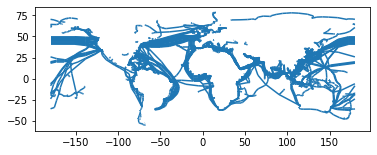

In [8]:
gdf.plot()
# gdf.to_csv("/Users/dijiongyuequ/Downloads/345.csv")

In [9]:
gdf = gdf.reset_index( )


In [10]:
gdf.sample(5)

,index,lon1,lat1,capacity,cost,cable_id,cable_name,lon2,lat2,fr_point,to_point,fr_id,to_id,distance_from_previous,line,geometry
493,493,-148.056462,60.658770,0.010000,90.000,northstar,NorthStar,-148.060812,60.691197,POINT (-148.05646 60.65877),POINT (-148.06081 60.69120),-8739769.0,-8736961.0,0.032718,LINESTRING (-148.05646168643068 60.65876959082...,"LINESTRING (-148.05646 60.65877, -148.06081 60..."
7627,7627,56.981284,26.159308,80.000000,800.000,asia-africa-europe-1-aae-1,Asia Africa Europe-1 (AAE-1),56.925034,25.348717,POINT (56.98128 26.15931),POINT (56.92503 25.34872),8314059.0,8227375.0,0.812540,LINESTRING (56.981283869863745 26.159307970773...,"LINESTRING (56.98128 26.15931, 56.92503 25.34872)"
3915,3915,104.034626,0.793563,10.515897,6.675,jambi-batam-cable-system-jiba,Jambi-Batam Cable System (JIBA),104.006576,0.906050,POINT (104.03463 0.79356),POINT (104.00658 0.90605),10482819.0,10491263.0,0.115932,LINESTRING (104.03462553683514 0.7935626526072...,"LINESTRING (104.03463 0.79356, 104.00658 0.90605)"
8488,8488,56.362534,26.461844,2.560000,900.000,falcon,FALCON,56.246814,26.181305,POINT (56.36253 26.46184),POINT (56.24681 26.18131),8282437.0,8242812.0,0.303468,LINESTRING (56.36253430819161 26.4618437961890...,"LINESTRING (56.36253 26.46184, 56.24681 26.18131)"
689,689,-152.999817,59.565883,5.911401,53.380,terra-sw,TERRA SW,-152.099818,59.622822,POINT (-152.99982 59.56588),POINT (-152.09982 59.62282),-9343394.0,-9247700.0,0.901799,LINESTRING (-152.99981737755388 59.56588346342...,"LINESTRING (-152.99982 59.56588, -152.09982 59..."


In [11]:
gdf[gdf['cable_name'] == 'Tata TGN-Gulf']

,index,lon1,lat1,capacity,cost,cable_id,cable_name,lon2,lat2,fr_point,to_point,fr_id,to_id,distance_from_previous,line,geometry
9092,9092,61.875030,22.469444,1.28,200.0,tata-tgn-gulf,Tata TGN-Gulf,61.875030,18.678647,POINT (61.87503 22.46944),POINT (61.87503 18.67865),8434447.0,8055368.0,3.790797,LINESTRING (61.87503040308769 22.4694439648295...,"LINESTRING (61.87503 22.46944, 61.87503 18.67865)"
9093,9093,59.850032,23.814221,1.28,200.0,tata-tgn-gulf,Tata TGN-Gulf,61.875030,22.469444,POINT (59.85003 23.81422),POINT (61.87503 22.46944),8366425.0,8434447.0,2.430852,LINESTRING (59.85003183761572 23.8142205150263...,"LINESTRING (59.85003 23.81422, 61.87503 22.46944)"
9094,9094,58.500033,24.430272,1.28,200.0,tata-tgn-gulf,Tata TGN-Gulf,59.850032,23.814221,POINT (58.50003 24.43027),POINT (59.85003 23.81422),8293030.0,8366425.0,1.483919,LINESTRING (58.50003279396768 24.4302719280485...,"LINESTRING (58.50003 24.43027, 59.85003 23.81422)"
9095,9095,57.037534,25.145210,1.28,200.0,tata-tgn-gulf,Tata TGN-Gulf,58.500033,24.430272,POINT (57.03753 25.14521),POINT (58.50003 24.43027),8218274.0,8293030.0,1.627894,LINESTRING (57.03753383001572 25.1452102274012...,"LINESTRING (57.03753 25.14521, 58.50003 24.43027)"
9096,9096,56.812534,25.348717,1.28,200.0,tata-tgn-gulf,Tata TGN-Gulf,57.037534,25.145210,POINT (56.81253 25.34872),POINT (57.03753 25.14521),8216125.0,8218274.0,0.303381,LINESTRING (56.81253398940768 25.3487174221168...,"LINESTRING (56.81253 25.34872, 57.03753 25.14521)"
9097,9097,56.925034,26.159308,1.28,200.0,tata-tgn-gulf,Tata TGN-Gulf,56.812534,25.348717,POINT (56.92503 26.15931),POINT (56.81253 25.34872),8308434.0,8216125.0,0.818360,LINESTRING (56.9250339097116 26.15930797077379...,"LINESTRING (56.92503 26.15931, 56.81253 25.34872)"
9098,9098,56.756284,26.562513,1.28,200.0,tata-tgn-gulf,Tata TGN-Gulf,56.925034,26.159308,POINT (56.75628 26.56251),POINT (56.92503 26.15931),8331879.0,8308434.0,0.437094,LINESTRING (56.75628402925571 26.5625131492366...,"LINESTRING (56.75628 26.56251, 56.92503 26.15931)"
9099,9099,56.250034,26.612815,1.28,200.0,tata-tgn-gulf,Tata TGN-Gulf,56.756284,26.562513,POINT (56.25003 26.61281),POINT (56.75628 26.56251),8286284.0,8331879.0,0.508743,LINESTRING (56.250034387887666 26.612814708603...,"LINESTRING (56.25003 26.61281, 56.75628 26.56251)"
9100,9100,55.800035,26.260241,1.28,200.0,tata-tgn-gulf,Tata TGN-Gulf,56.250034,26.612815,POINT (55.80003 26.26024),POINT (56.25003 26.61281),8206027.0,8286284.0,0.571671,LINESTRING (55.800034706671596 26.260240971577...,"LINESTRING (55.80003 26.26024, 56.25003 26.61281)"
9101,9101,55.350035,26.058288,1.28,200.0,tata-tgn-gulf,Tata TGN-Gulf,55.800035,26.260241,POINT (55.35004 26.05829),POINT (55.80003 26.26024),8140833.0,8206027.0,0.493239,LINESTRING (55.350035025455725 26.058287560298...,"LINESTRING (55.35004 26.05829, 55.80003 26.26024)"


In [12]:
gdf[gdf['to_id'] == 8220624.0]

,index,lon1,lat1,capacity,cost,cable_id,cable_name,lon2,lat2,fr_point,to_point,fr_id,to_id,distance_from_previous,line,geometry
4185,4185,58.950032,23.762750,0.139855,1007.78,seamewe-3,SeaMeWe-3,58.591143,23.615105,POINT (58.95003 23.76275),POINT (58.59114 23.61510),8271278.0,8220624.0,0.388073,LINESTRING (58.950032475183775 23.762749511610...,"LINESTRING (58.95003 23.76275, 58.59114 23.61510)"
8299,8299,58.950032,23.865671,18.706918,532.78,seamewe-5,SeaMeWe-5,58.591143,23.615105,POINT (58.95003 23.86567),POINT (58.59114 23.61510),8281570.0,8220624.0,0.437705,LINESTRING (58.950032475183775 23.865671119262...,"LINESTRING (58.95003 23.86567, 58.59114 23.61510)"
9113,9113,58.950032,23.814221,1.280000,200.00,tata-tgn-gulf,Tata TGN-Gulf,58.591143,23.615105,POINT (58.95003 23.81422),POINT (58.59114 23.61510),8276425.0,8220624.0,0.410425,LINESTRING (58.950032475183775 23.814220515025...,"LINESTRING (58.95003 23.81422, 58.59114 23.61510)"


In [13]:
G = nx.from_pandas_edgelist(gdf, 'fr_id', 'to_id', edge_attr=['capacity'], create_using=nx.Graph)


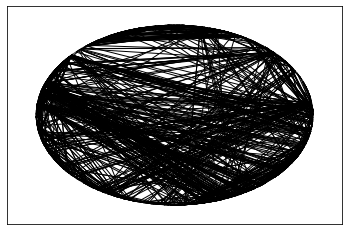

In [14]:
nx.draw_networkx_edges(G, pos=nx.circular_layout(G))


In [15]:
flow_value, flow_dict = nx.maximum_flow(G, 5733355, 8283829,capacity = 'capacity')  # 求网络最大流

flow = nx.maximum_flow_value(G, -7078476.0, 6796544)  # 求网络最大流

In [16]:
# print(flow)
print(f"The max flow between two locations is:{flow_value}")
# flow_dict

The max flow between two locations is:5.12


In [17]:

edgeCapacity = nx.get_edge_attributes(G, 'capacity')

edgeDict = {}  # 记录容量线路     外层的key为容量 value为一个记录该容量下的路径   内层的key为开始节点, value为结束节点

for i in flow_dict.keys():
    for j in flow_dict[i].keys():
        capacityBetweenTwoEdges = flow_dict[i][j]
        if flow_dict[i][j] > 0 :  # 网络最大流的边（流量>0）
            if capacityBetweenTwoEdges not in edgeDict: edgeDict[capacityBetweenTwoEdges] = {}
            edgeDict[capacityBetweenTwoEdges][i] = j
          


def num2color(values, cmap):
    """将数值映射为颜色"""
    norm = mpl.colors.Normalize(vmin=np.min(values), vmax=np.max(values))
    cmap = mpl.cm.get_cmap(cmap)
    return [cmap(norm(val)) for val in values]


temp = set()    

def getPath(path, road):

    pathroad = pd.DataFrame()
    for capacity in path:
        temp.add(capacity)
        for startNode, endNode  in path[capacity].items():
            # print(startNode, endNode)
            # len(path.keys())-1
            # fr_id and to_id might be in opposite order
            r = road[ (((road['fr_id'] == startNode) & (road['to_id'] == endNode)) | ((road['fr_id'] == endNode) & (road['to_id'] == startNode))) ]

            pathroad = pathroad.append(r)
    return pathroad
unfiltered_gdf = getPath(edgeDict, gdf)


In [18]:

# Make a dictionary to map the capacity to a color from cmap
def sortCapacityList(capacityList):
    capacityList = list(set(temp))
    capacityList.sort(reverse= True)
    return capacityList
map_capacityColor = dict (zip( sortCapacityList(temp) , num2color(range(len(temp)), "RdBu") ))
# map_capacityColor
unfiltered_gdf = unfiltered_gdf[unfiltered_gdf['capacity'].isin(set(temp))]



In [19]:
for capacities in sortCapacityList(edgeDict.keys()):
    print(f"Capacity option to the destination: {capacities}")

Capacity option to the destination: 2.56
Capacity option to the destination: 1.28
Capacity option to the destination: 0.9271626141986448
Capacity option to the destination: 0.7873079765691885
Capacity option to the destination: 0.35283738580135526
Capacity option to the destination: 0.13985463762945624


(0.0, 35.0)

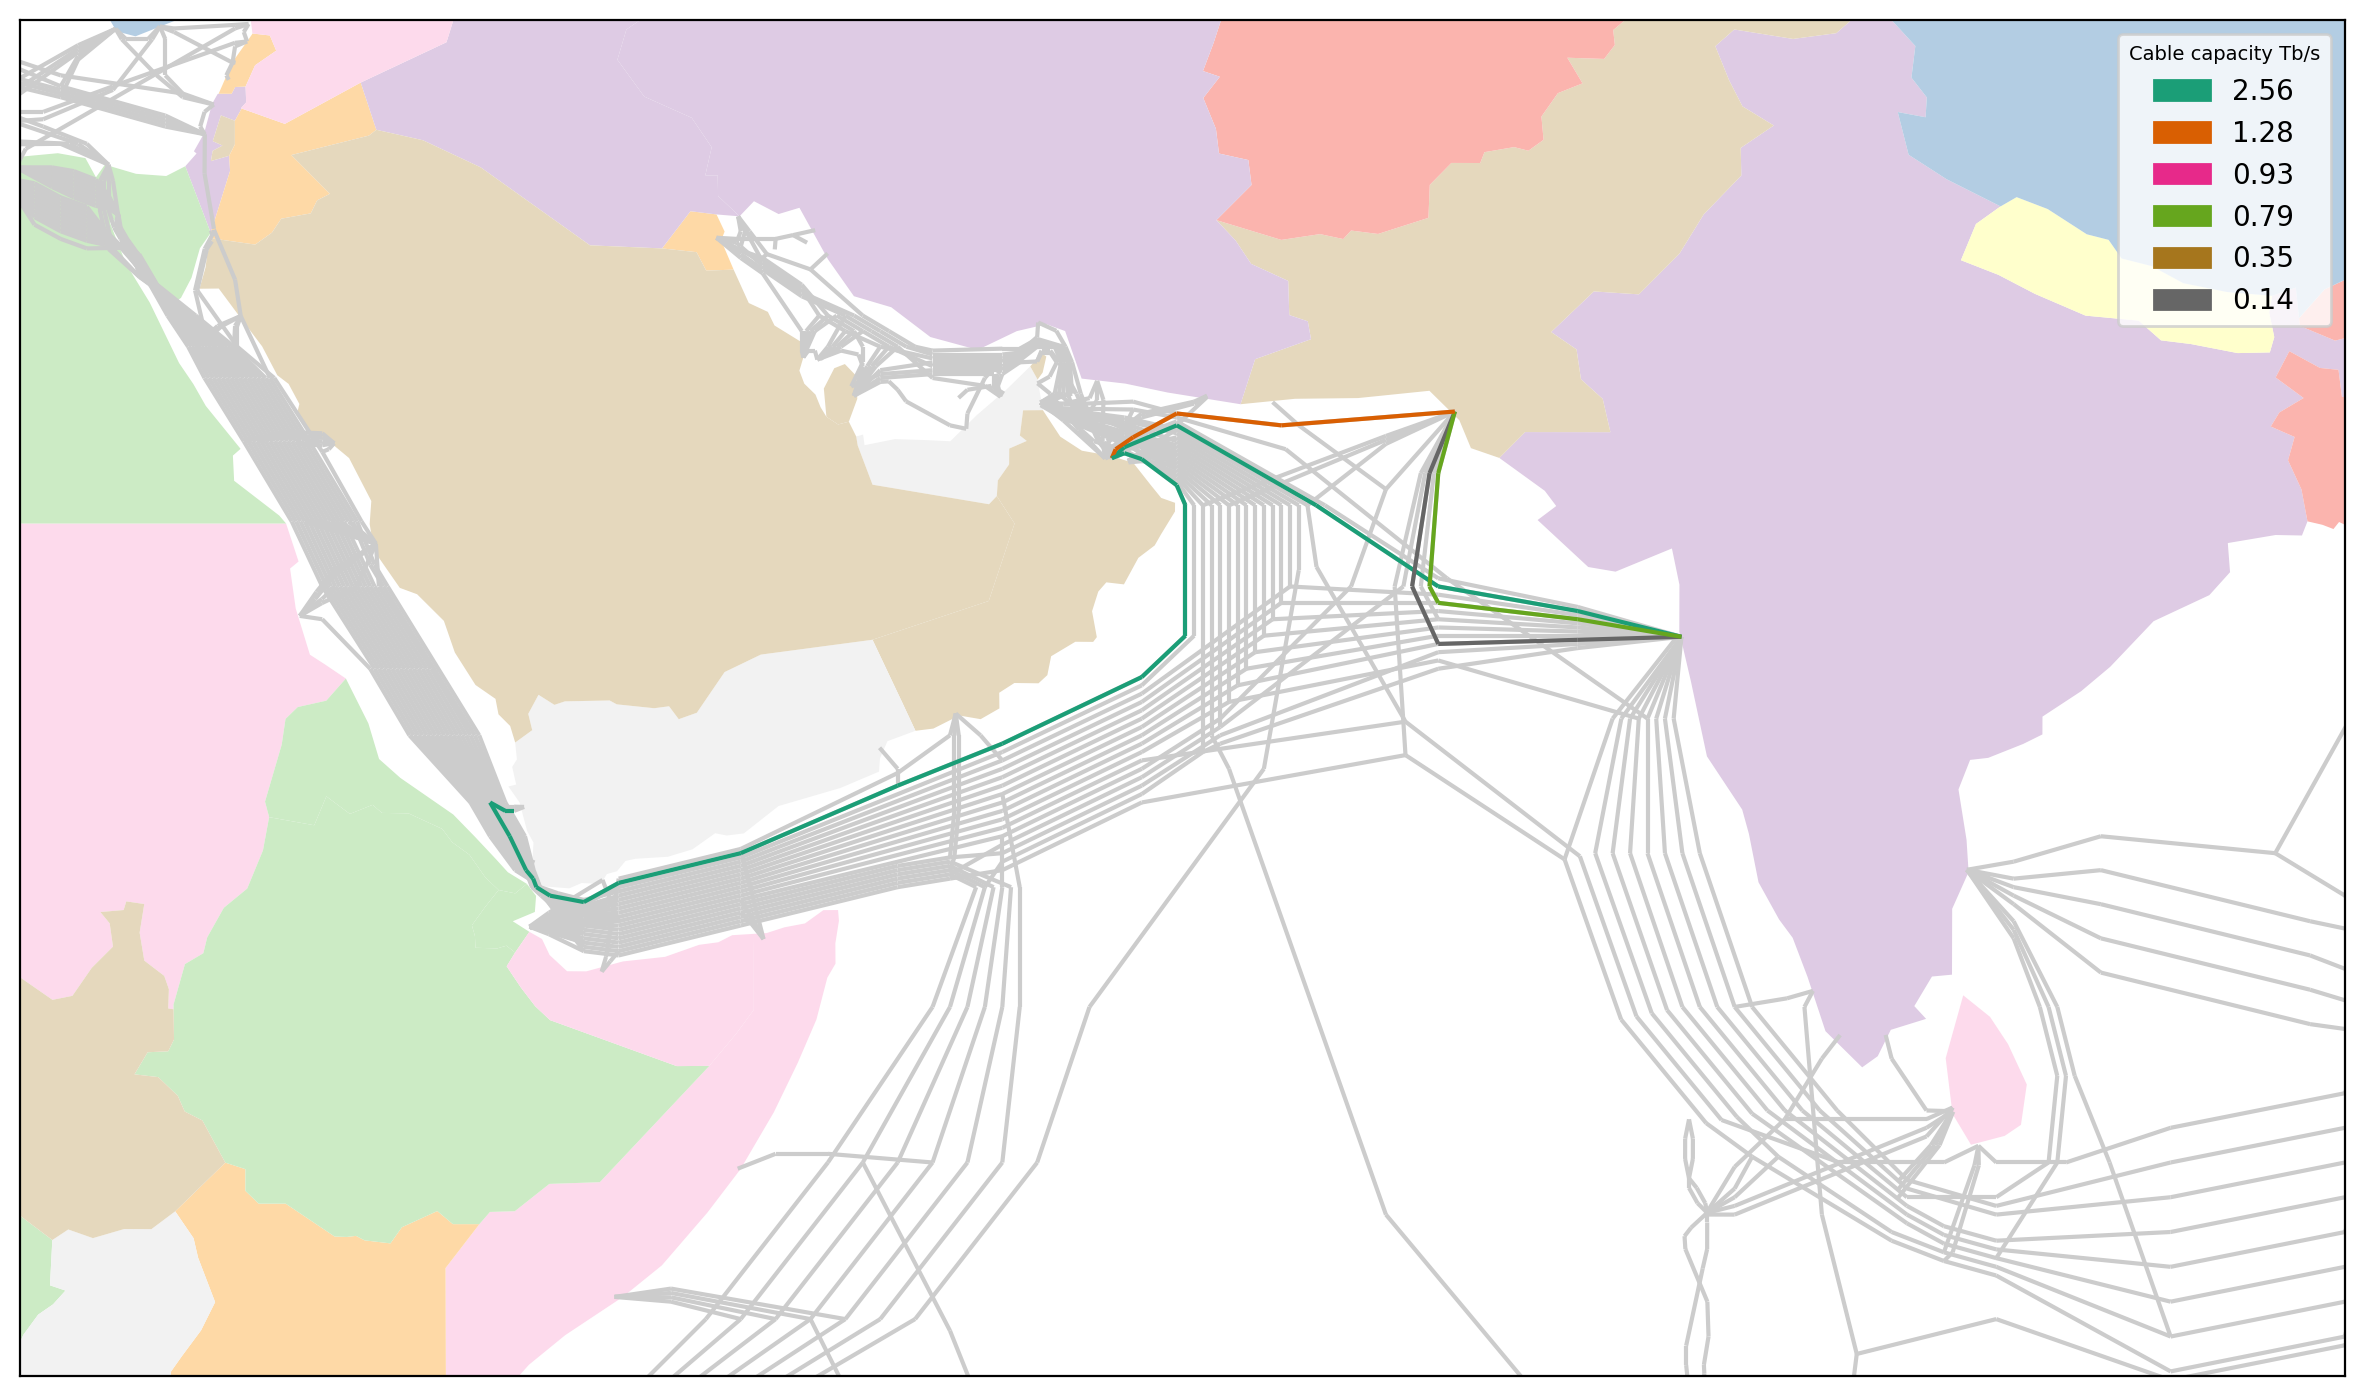

In [27]:
map_capacityColor = dict (zip(  sortCapacityList(temp), num2color(range(len(temp)), "Dark2") ))
unfiltered_gdf['color'] = unfiltered_gdf["capacity"].map(map_capacityColor)
# [round(x,2) for x in sortCapacityList(temp)]


fig     = plt.figure(figsize=(15,10),dpi = 200)
ax      = plt.subplot(111)

worldMap.plot(column='name', ax=ax, legend=False,cmap='Pastel1',aspect=1,legend_kwds={'loc': 'lower left'})
gdf.plot(ax=ax, color=plt.cm.get_cmap('Pastel2')(0.9))

unfiltered_gdf.plot(ax = ax, color=unfiltered_gdf['color'],legend=True)

capacity_legend_element_list = []
for capacities in map_capacityColor:
    patch = mpatches.Patch(color=map_capacityColor[capacities], label=round(capacities,2))
    capacity_legend_element_list.append(patch)
    
ax.margins(0)
ax.tick_params(left=False, labelleft=False, bottom=False, labelbottom=False)
plt.legend(handles=capacity_legend_element_list, title='Cable capacity Tb/s',fontsize=10, title_fontsize= 7)

plt.xlim(30,90)
plt.ylim(0,35)

In [21]:
unfiltered_gdf

,index,lon1,lat1,capacity,cost,cable_id,cable_name,lon2,lat2,fr_point,to_point,fr_id,to_id,distance_from_previous,line,geometry,color
8443,8443,70.200025,19.740987,2.560000,900.00,falcon,FALCON,72.875903,19.076074,POINT (70.20002 19.74099),POINT (72.87590 19.07607),8994101.0,9195197.0,2.757251,LINESTRING (70.2000245055838 19.74098736552503...,"LINESTRING (70.20002 19.74099, 72.87590 19.07607)","(0.10588235294117647, 0.6196078431372549, 0.46..."
8447,8447,58.500033,23.968511,2.560000,900.00,falcon,FALCON,59.850032,24.532658,POINT (58.50003 23.96851),POINT (59.85003 24.53266),8246854.0,8438269.0,1.463133,LINESTRING (58.50003279396768 23.9685109967347...,"LINESTRING (58.50003 23.96851, 59.85003 24.53266)","(0.10588235294117647, 0.6196078431372549, 0.46..."
8444,8444,66.600027,20.375041,2.560000,900.00,falcon,FALCON,70.200025,19.740987,POINT (66.60003 20.37504),POINT (70.20002 19.74099),8697507.0,8994101.0,3.655408,LINESTRING (66.60002705585575 20.3750412534655...,"LINESTRING (66.60003 20.37504, 70.20002 19.74099)","(0.10588235294117647, 0.6196078431372549, 0.46..."
8445,8445,63.450029,22.469444,2.560000,900.00,falcon,FALCON,66.600027,20.375041,POINT (63.45003 22.46944),POINT (66.60003 20.37504),8591947.0,8697507.0,3.782725,LINESTRING (63.450029287343796 22.469443964829...,"LINESTRING (63.45003 22.46944, 66.60003 20.37504)","(0.10588235294117647, 0.6196078431372549, 0.46..."
8446,8446,59.850032,24.532658,2.560000,900.00,falcon,FALCON,63.450029,22.469444,POINT (59.85003 24.53266),POINT (63.45003 22.46944),8438269.0,8591947.0,4.149317,LINESTRING (59.85003183761572 24.5326575661624...,"LINESTRING (59.85003 24.53266, 63.45003 22.46944)","(0.10588235294117647, 0.6196078431372549, 0.46..."
8448,8448,58.176203,23.684878,2.560000,900.00,falcon,FALCON,58.500033,23.968511,POINT (58.17620 23.68488),POINT (58.50003 23.96851),8186108.0,8246854.0,0.430481,LINESTRING (58.17620302337187 23.6848775316846...,"LINESTRING (58.17620 23.68488, 58.50003 23.96851)","(0.10588235294117647, 0.6196078431372549, 0.46..."
4255,4255,70.200025,18.998068,0.139855,1007.78,seamewe-3,SeaMeWe-3,72.875903,19.076074,POINT (70.20002 18.99807),POINT (72.87590 19.07607),8919809.0,9195197.0,2.677015,LINESTRING (70.2000245055838 18.99806752594906...,"LINESTRING (70.20002 18.99807, 72.87590 19.07607)","(0.4, 0.4, 0.4, 1.0)"
4256,4256,66.600027,18.891662,0.139855,1007.78,seamewe-3,SeaMeWe-3,70.200025,18.998068,POINT (66.60003 18.89166),POINT (70.20002 18.99807),8549169.0,8919809.0,3.601570,LINESTRING (66.60002705585575 18.8916615843032...,"LINESTRING (66.60003 18.89166, 70.20002 18.99807)","(0.4, 0.4, 0.4, 1.0)"
4349,4349,65.925028,20.375041,0.139855,1007.78,seamewe-3,SeaMeWe-3,66.600027,18.891662,POINT (65.92503 20.37504),POINT (66.60003 18.89166),8630007.0,8549169.0,1.629736,LINESTRING (65.92502753403164 20.3750412534655...,"LINESTRING (65.92503 20.37504, 66.60003 18.89166)","(0.4, 0.4, 0.4, 1.0)"
4350,4350,66.375027,23.298598,0.139855,1007.78,seamewe-3,SeaMeWe-3,65.925028,20.375041,POINT (66.37503 23.29860),POINT (65.92503 20.37504),8967363.0,8630007.0,2.957987,LINESTRING (66.37502721524771 23.2985980658758...,"LINESTRING (66.37503 23.29860, 65.92503 20.37504)","(0.4, 0.4, 0.4, 1.0)"


In [22]:
set(unfiltered_gdf["capacity"])

{0.13985463762945624, 0.7873079765691885, 1.28, 2.56}

In [23]:
# Test Code

# temp_dic = {5059775.0: {5069405.0: 1, 5047299.0: 0},
#  5069405.0: {5059775.0: 1}}
# dgeCapacity = nx.get_edge_attributes(G, 'capacity')
# edgeLabel = {}  # 边的标签
# for i in edgeCapacity.keys():  # 整理边的标签，用于绘图显示
#     edgeLabel[i] = f'c={edgeCapacity[i]:}'  # 边的容量
# edgeDict = {}  # 记录容量线路     外层的key为容量 value为一个记录该容量下的路径   内层的key为开始节点, value为结束节点

# for i in temp_dic.keys():
#     for j in temp_dic[i].keys():
#         capacityBetweenTwoEdges = temp_dic[i][j]
#         if temp_dic[i][j] > 0 :  # 网络最大流的边（流量>0）
#             if capacityBetweenTwoEdges not in edgeDict: edgeDict[capacityBetweenTwoEdges] = {}
#             edgeDict[capacityBetweenTwoEdges][i] = j
            
# edgeDict

In [24]:
maxFlowValue, maxFlowDict = nx.maximum_flow(G, 15272016, 4629267)  # 求网络最大流

# 数据格式转换
edgeCapacity = nx.get_edge_attributes(G, 'capacity')
edgeLabel = {}  # 边的标签
for i in edgeCapacity.keys():  # 整理边的标签，用于绘图显示
    edgeLabel[i] = f'c={edgeCapacity[i]:}'  # 边的容量
edgeLists = []  # 最大流的边的 list
for i in maxFlowDict.keys():
    for j in maxFlowDict[i].keys():
        edgeLabel[(i, j)] += ',f=' + str(maxFlowDict[i][j])  # 取出每条边流量信息存入边显示值
        if maxFlowDict[i][j] > 0:  # 网络最大流的边（流量>0）
            edgeLists.append((i,j))

# 输出显示
print("最大流值: ", maxFlowValue)
print("最大流的途径及流量: ", maxFlowDict)  # 输出最大流的途径和各路径上的流量
print("最大流的路径：", edgeLists)  # 输出最大流的途径

KeyError: (5069405.0, 5059775.0)

In [ ]:
path = nx.shortest_path(G, -7078476.0, 6796544, weight = 'length')

# def getPath(path, road):
#     pathroad = pd.DataFrame()
#     for i in range(5):
#         # len(path.keys())-1
#         node1 = path[list (path.keys())[i]]
#         print(node1)
#         node2 = path[list (path.keys())[i+1]]
#         print(node2)
#         r = road[(road['fr_id'] == node1) & (road['to_id'] == node2)]
#         pathroad = pathroad.append(r)
#     return pathroad

def getPath(path, road):
    pathroad = pd.DataFrame()
    for i in range(len(path)-1):
        # len(path.keys())-1
        node1 = path[i]
        node2 = path[i+1]
        # fr_id and to_id might be in opposite order
        r = road[ ((road['fr_id'] == node1) & (road['to_id'] == node2)) | (road['fr_id'] == node2) & (road['to_id'] == node1) ]
        pathroad = pathroad.append(r)
    return pathroad